<a href="https://colab.research.google.com/github/XiaobingDean/MNIST/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import torch

from torchvision.datasets import mnist

from torchvision import transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
train_batch_size = 64
test_batch_size = 128

learning_rate = 0.01
nums_epoches = 20

lr = 0.1
momentum = 0.5

In [6]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
train_dataset = mnist.MNIST('./data', train=True, transform=transform, target_transform=None, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform, target_transform=None, download=False)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


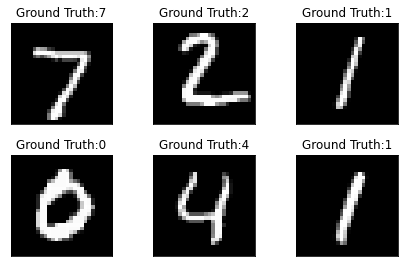

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
examples = enumerate(test_loader)
batch_idx,(example_data,example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray',interpolation='none')
    plt.title("Ground Truth:{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [8]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [9]:
class CNN(nn.Module):
    def __init__(self,in_dim,hidden_1,hidden_2,out_dim):
        super(CNN,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, hidden_1, bias=True),nn.BatchNorm1d(hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(hidden_1,hidden_2,bias=True),nn.BatchNorm1d(hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(hidden_2,out_dim))
        
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [12]:
losses = []
acces = []

eval_losses = []
eval_acces = []

for epoch in range(nums_epoches):

    train_loss = 0
    train_acc = 0

    model.train()

    if epoch%5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
    for img,label in train_loader:

        img = img.view(img.size(0),-1)
        
        out = model(img)

        loss = criterion(out,label)

        optimizer.zero_grad()
        loss.backward()
 
        optimizer.step()

        train_loss += loss.item()

        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        train_acc += acc
    losses.append(train_loss/len(train_loader))
    acces.append(train_acc/len(train_loader))
    
    eval_loss = 0
    eval_acc = 0
    model.eval()
    for img,label in test_loader:
        img = img.view(img.size(0),-1)
        
        out = model(img)
        loss = criterion(out,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        eval_loss += loss.item()
        
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        eval_acc += acc
    eval_losses.append(eval_loss/len(test_loader))
    eval_acces.append(eval_acc/len(test_loader))

    print('epoch:{},Train Loss:{:.4f},Train Acc:{:.4f},Test Loss:{:.4f},Test Acc:{:.4f}'
             .format(epoch,train_loss/len(train_loader),train_acc/len(train_loader),
                    eval_loss/len(test_loader),eval_acc/len(test_loader)))

epoch:0,Train Loss:0.3529,Train Acc:0.9166,Test Loss:0.1541,Test Acc:0.9528
epoch:1,Train Loss:0.1290,Train Acc:0.9650,Test Loss:0.0999,Test Acc:0.9697
epoch:2,Train Loss:0.0864,Train Acc:0.9765,Test Loss:0.0847,Test Acc:0.9733
epoch:3,Train Loss:0.0672,Train Acc:0.9811,Test Loss:0.0753,Test Acc:0.9760
epoch:4,Train Loss:0.0526,Train Acc:0.9857,Test Loss:0.0594,Test Acc:0.9815
epoch:5,Train Loss:0.0382,Train Acc:0.9907,Test Loss:0.0302,Test Acc:0.9919
epoch:6,Train Loss:0.0344,Train Acc:0.9921,Test Loss:0.0292,Test Acc:0.9925
epoch:7,Train Loss:0.0327,Train Acc:0.9928,Test Loss:0.0286,Test Acc:0.9924
epoch:8,Train Loss:0.0319,Train Acc:0.9926,Test Loss:0.0279,Test Acc:0.9931
epoch:9,Train Loss:0.0303,Train Acc:0.9932,Test Loss:0.0273,Test Acc:0.9930
epoch:10,Train Loss:0.0291,Train Acc:0.9937,Test Loss:0.0276,Test Acc:0.9935
epoch:11,Train Loss:0.0290,Train Acc:0.9941,Test Loss:0.0268,Test Acc:0.9935
epoch:12,Train Loss:0.0294,Train Acc:0.9939,Test Loss:0.0260,Test Acc:0.9938
epoch:13,

In [13]:
losses_pgd = []
acces_pgd = []

eval_losses_pgd = []
eval_acces_pgd = []

for epoch in range(nums_epoches):

    train_loss = 0
    train_acc = 0

    model_2.train()

    if epoch%5 == 0:
        optimizer_2.param_groups[0]['lr'] *= 0.1
    for img,label in train_loader:

        img = img.view(img.size(0),-1)

        img_pgd = img + pgd(model_2, img, label, 1e-1, 1e-3, 1)
        
        out = model_2(img_pgd)

        loss = criterion_2(out,label)

        optimizer_2.zero_grad()
        loss.backward()
 
        optimizer_2.step()

        train_loss += loss.item()

        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        train_acc += acc
    losses_pgd.append(train_loss/len(train_loader))
    acces_pgd.append(train_acc/len(train_loader))
    
    eval_loss = 0
    eval_acc = 0
    model_2.eval()
    for img,label in test_loader:
        img = img.view(img.size(0),-1)
        
        out = model_2(img)
        loss = criterion_2(out,label)
        
        optimizer_2.zero_grad()
        loss.backward()
        optimizer_2.step()
        
        eval_loss += loss.item()
        
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct/img.shape[0]
        eval_acc += acc
    eval_losses_pgd.append(eval_loss/len(test_loader))
    eval_acces_pgd.append(eval_acc/len(test_loader))

    print('epoch:{},Train Loss:{:.4f},Train Acc:{:.4f},Test Loss:{:.4f},Test Acc:{:.4f}'
             .format(epoch,train_loss/len(train_loader),train_acc/len(train_loader),
                    eval_loss/len(test_loader),eval_acc/len(test_loader)))

epoch:0,Train Loss:2.4148,Train Acc:0.0953,Test Loss:2.4178,Test Acc:0.0927
epoch:1,Train Loss:2.4149,Train Acc:0.0948,Test Loss:2.4170,Test Acc:0.0930
epoch:2,Train Loss:2.4142,Train Acc:0.0952,Test Loss:2.4134,Test Acc:0.0938
epoch:3,Train Loss:2.4140,Train Acc:0.0957,Test Loss:2.4143,Test Acc:0.0940
epoch:4,Train Loss:2.4140,Train Acc:0.0960,Test Loss:2.4177,Test Acc:0.0951
epoch:5,Train Loss:2.4153,Train Acc:0.0948,Test Loss:2.4093,Test Acc:0.0961
epoch:6,Train Loss:2.4152,Train Acc:0.0963,Test Loss:2.4175,Test Acc:0.0940
epoch:7,Train Loss:2.4148,Train Acc:0.0952,Test Loss:2.4159,Test Acc:0.0937
epoch:8,Train Loss:2.4145,Train Acc:0.0956,Test Loss:2.4075,Test Acc:0.0937
epoch:9,Train Loss:2.4152,Train Acc:0.0961,Test Loss:2.4125,Test Acc:0.0957
epoch:10,Train Loss:2.4147,Train Acc:0.0949,Test Loss:2.4165,Test Acc:0.0958
epoch:11,Train Loss:2.4150,Train Acc:0.0954,Test Loss:2.4136,Test Acc:0.0972
epoch:12,Train Loss:2.4146,Train Acc:0.0967,Test Loss:2.4084,Test Acc:0.0971
epoch:13,

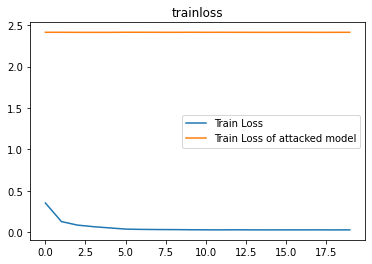

In [14]:
plt.title('trainloss')
plt.plot(np.arange(len(losses)),losses, np.arange(len(losses_pgd)),losses_pgd)
plt.legend(['Train Loss', 'Train Loss of attacked model'],loc='right')